In [496]:
import sys
sys.path.append('../')
from initial_classif.classifier.classifier import binary_classification
from fine_classif.feat_extract.compute_feats import correct_to_HJD, sigclipper
import pickle
import glob
import sqlutilpy as sqlutil
from config import configuration
from scipy.optimize import minimize

from astropy.utils.iers import IERS_A_URL, IERS_B_URL, conf
from astropy.utils.data import download_file

conf.auto_download = True
download_file(IERS_A_URL, cache="update")
download_file(IERS_B_URL, cache="update")
conf.auto_download = False

config = configuration()
config.request_password()

 ·············


In [497]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_classifier.pkl', 'rb') as f:
    var = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_training_set.pkl', 'rb') as f:
    var_dataset_scaled = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    var_dataset_full = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_mira.pkl', 'rb') as f:
    mira_features = pickle.load(f)
var_dataset_full = pd.concat([var_dataset_full, mira_features], axis=0)
var_dataset = var_dataset_full.merge(var_dataset_scaled[['sourceid', 'class', 'prob']], on='sourceid')
var_dataset_full = var_dataset_full[(~var_dataset_full['error'])].reset_index(drop=True)

/data/jls/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [4]:
def sigclipper(x, sig_thresh=5):
    stdd = .5 * np.diff(np.nanpercentile(x, [16, 84]))
    midd = np.nanmedian(x)
    return (np.abs(x - midd) / stdd < sig_thresh)

In [478]:
def compute_amplitudes(typee = 'Ell', fltr=None, Nlimit=100, min_filter=1):
    print(typee)
    S = var_dataset[(var_dataset['var_class']==typee)&(var_dataset['log10_fap_ls']<-10)].reset_index(drop=True)
    S = S.sample(Nlimit, random_state=42).reset_index(drop=True)
    S = S.sort_values(by='sourceid').reset_index(drop=True)
    
    ss = pd.DataFrame(sqlutil.get('''select sourceid, 
                                    unnest(mjdobs) as mjdobs,
                                    unnest(mag) as mag,
                                    unnest(ast_res_chisq) as ast_res_chisq,
                                    unnest(ambiguous_match) as ambiguous_match,
                                    unnest(chi) as chi,
                                    unnest(filterid) as fid,
                                    unnest(emag) as error from leigh_smith.virac2_ts_tmolnar_train_zyjhk 
                                    where sourceid in (%s);'''%(','.join([str(s) for s in S['sourceid'].values])),
                                           **config.wsdb_kwargs))

    ss = ss[(ss['mag']>0.)&(ss['ast_res_chisq']<11.829)&(ss['ambiguous_match']==0)].reset_index(drop=True)
    ss = ss.sort_values(by=['sourceid', 'mjdobs']).reset_index(drop=True)

    ss = ss.groupby('sourceid', sort=True)    
    gk = list(ss.groups.keys())
    gk.sort()
    ss=[ss.get_group(x) for x in gk]

    [correct_to_HJD(sss, S['ra'].values[ii], S['dec'].values[ii]) for ii,sss in enumerate(ss)];
    
    ivw_ = lambda m, e: np.nansum(m/e**2)/np.nansum(1./e**2)
    
    def contemp_mag_scatter_ratio(lc, filter_id, filter_id_ref=5, tthresh=1./24.):
        
        Jtimes = lc['HJD'].values[lc['fid']==filter_id]
        Jmag = lc['mag'].values[lc['fid']==filter_id]
        Jmag_err = lc['error'].values[lc['fid']==filter_id]
        meanJ = ivw_(Jmag,Jmag_err)
        
        Ktimes = lc['HJD'].values[lc['fid']==filter_id_ref]
        Kmag = lc['mag'].values[lc['fid']==filter_id_ref]
        Kmag_err = lc['error'].values[lc['fid']==filter_id_ref]
        meanK = ivw_(Kmag,Kmag_err)
        
        tdiffs = np.abs(Jtimes[:,np.newaxis] - Ktimes[np.newaxis,:])
        tmin = np.min(tdiffs, axis=1)
        tamin = np.argmin(tdiffs, axis=1)

        fltrT = (tmin<tthresh)
        mean_k_err = np.nanmedian(Kmag_err[tamin][fltrT])
        mean_j_err = np.nanmedian(Jmag_err[fltrT])
        
        Jscatter = ivw_((Jmag[fltrT]-meanJ)**2,Jmag_err[fltrT]) - mean_j_err**2
        Kscatter = ivw_((Kmag[tamin][fltrT]-meanK)**2,Kmag_err[tamin][fltrT]) - mean_k_err**2

        abs_ratio = ivw_(np.abs((Jmag[fltrT]-meanJ)/(Kmag[tamin][fltrT]-meanK)), 
                         np.sqrt(Jmag_err[fltrT]*Kmag_err[tamin][fltrT]))
        
        return np.sqrt(Jscatter / Kscatter), abs_ratio

    def data_scatter_wrt_model(lc, amplitudes, phases, period):
        
        phase = (lc['HJD'] % period) * (2. * np.pi) / period
        n = np.arange(1, len(amplitudes)+1)
        mag = np.sum(amplitudes[:,np.newaxis] * np.cos(n[:,np.newaxis]*phase[np.newaxis,:]+phases[:,np.newaxis]), axis=0)
        
        meanJ = ivw_(lc['mag'].values,lc['error'].values)
        meanK = ivw_(mag,lc['error'].values)
        mean_err = np.nanmedian(lc['error'].values)
        
        Jscatter = ivw_((lc['mag'].values-meanJ)**2,lc['error'].values) - mean_err**2
        Kscatter = ivw_((mag-meanK)**2, lc['error'].values)
        
        if len(lc['mag'].values)>2:
            params=leastsq(lambda p: (mag*p[1]**2-(lc['mag'].values-meanJ)-p[0])/lc['error'].values, [0.,1.])[0]
            spread = params[1]**2
            if spread<1e-3:
                spread=np.nan
        else:
            spread=np.nan
            
        nobs = len(lc['mag'].values)
        
        return np.sqrt(Jscatter / Kscatter), spread, nobs
    
    
    fltr = {1:'Z',2:'Y',3:'J',4:'H',5:'Ks'}
    cols = ['%s_scale'%s for s in ['Z','Y','J','H','Ks']]+\
            ['%s_contemp_std'%s for s in ['Z','Y','J','H','Ks']]+\
            ['%s_model'%s for s in ['Z','Y','J','H','Ks']]+\
            ['%s_nobs'%s for s in ['Z','Y','J','H','Ks']]+\
            ['%s_contemp_abs'%s for s in ['Z','Y','J','H','Ks']]
    df = pd.DataFrame(index=np.arange(len(ss)), columns=cols, dtype=np.float64)
             
    for ii in range(len(ss)):

        for jj in range(1,6):
            
            df.iloc[ii]['%s_model'%fltr[jj]], df.iloc[ii]['%s_scale'%fltr[jj]], df.iloc[ii]['%s_nobs'%fltr[jj]] = \
                                         data_scatter_wrt_model(ss[ii][ss[ii]['fid']==jj],
                                              np.array([S['amp_%i'%kk].values[ii] for kk in range(4)]),
                                              np.array([S['phi_%i'%kk].values[ii] for kk in range(4)]),
                                              S['lsq_period'].values[ii])

            
            df.iloc[ii]['%s_contemp_std'%fltr[jj]], df.iloc[ii]['%s_contemp_abs'%fltr[jj]] = \
                contemp_mag_scatter_ratio(ss[ii], jj)
    
    return df, S, ss

In [480]:
rslts_RRab, S_RRab, _ = compute_amplitudes(typee='RRab')
rslts_Ell, S_Ell, _ = compute_amplitudes()
rslts_RRc, S_RRc, _ = compute_amplitudes(typee='RRc')
rslts_EW, S_EW, _ = compute_amplitudes(typee='EW')
rslts_EAB, S_EAB, _ = compute_amplitudes(typee='EA/EB')
rslts_T2C, S_T2C, _ = compute_amplitudes(typee='T2CEP')

RRab


/data/jls/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in float_scalars
/data/jls/python3.5/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in sqrt
/data/jls/python3.5/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in sqrt


Ell


/data/jls/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


RRc
EW
EA/EB
T2CEP


In [489]:
all_results = [rslts_RRab, rslts_Ell, rslts_RRc, rslts_EW, rslts_EAB, rslts_T2C]
label = ['RRab', 'Ell', 'RRc', 'EW', 'EAB', 'T2C']

In [492]:
def kplot(val, nobs, l):
    fltr = (nobs>2)&(val==val)
    if np.count_nonzero(fltr)>1:
        sns.kdeplot(val[fltr],label=l,lw=3,clip=[0,4])

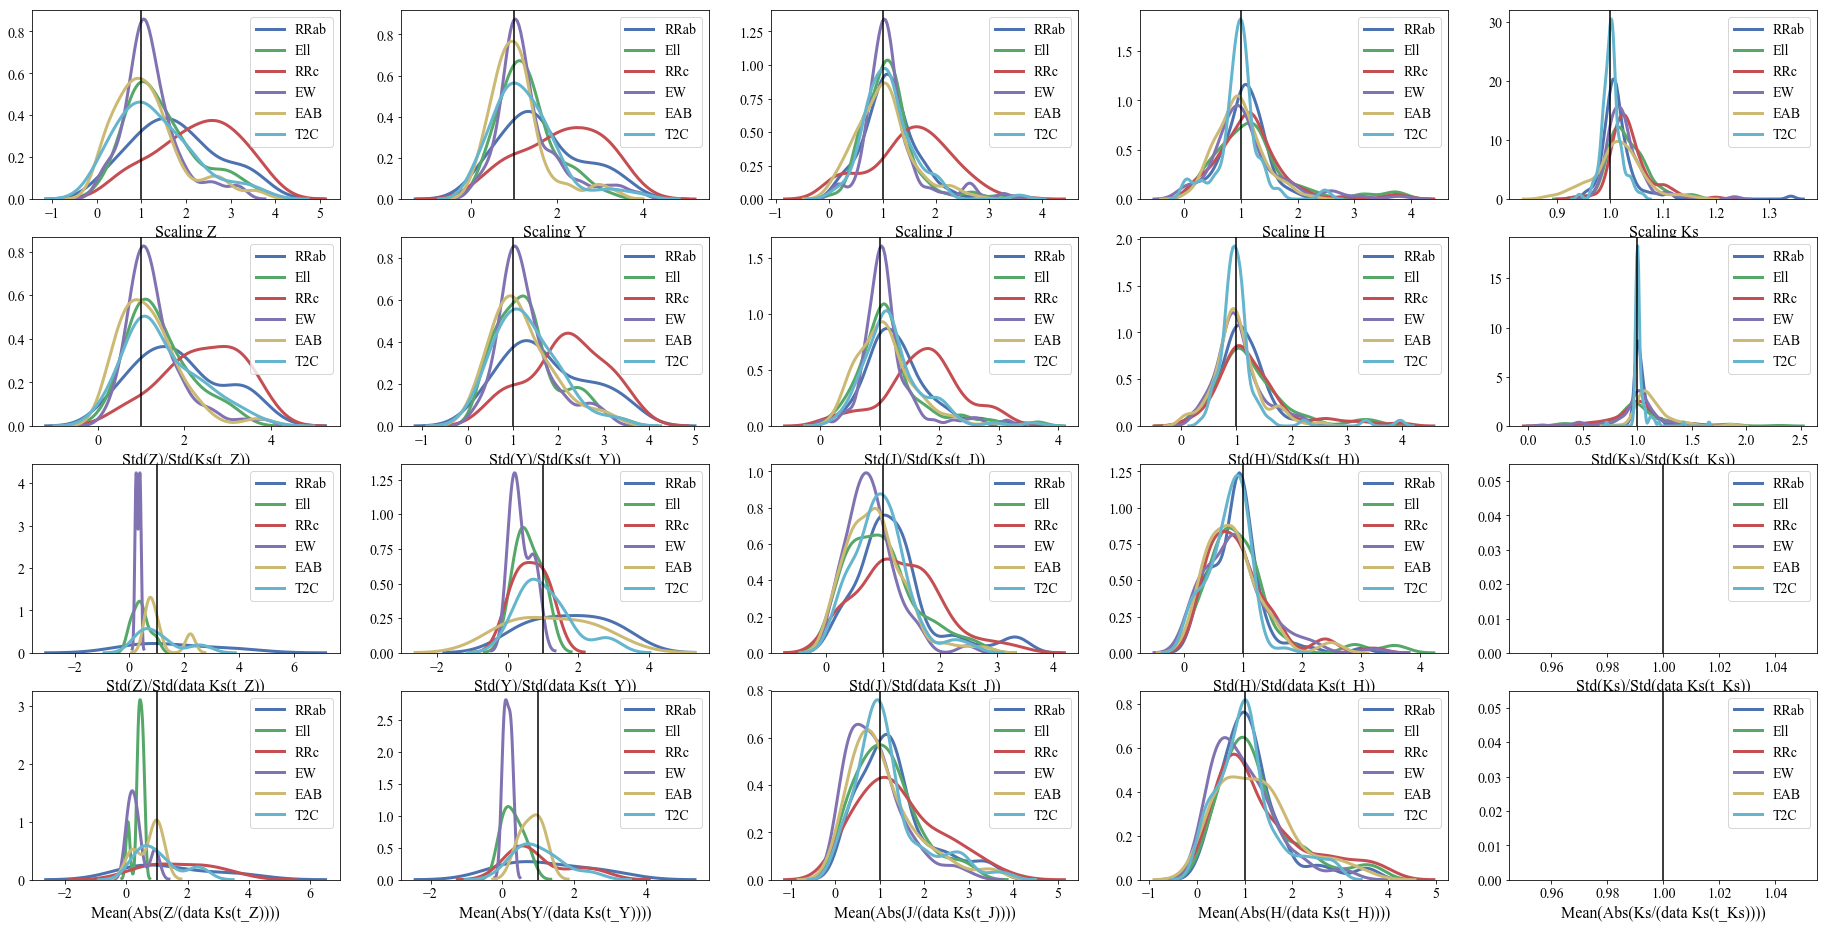

In [493]:
import seaborn as sns
f,a=plt.subplots(4,5,figsize=[32,16])
for ii, ff in enumerate(['Z','Y','J','H','Ks']):
    plt.sca(a[0][ii])
    [kplot(r['%s_scale'%ff].values, r['%s_nobs'%ff].values, l) for r, l in zip(all_results, label)]
    plt.axvline(1.,color='k')
    plt.xlabel('Scaling %s'%ff)
for ii, ff in enumerate(['Z','Y','J','H','Ks']):
    plt.sca(a[1][ii])
    [kplot(r['%s_model'%ff].values, r['%s_nobs'%ff].values, l) for r, l in zip(all_results, label)]
    plt.axvline(1.,color='k')
    plt.xlabel('Std({0})/Std(Ks(t_{0}))'.format(ff))
for ii, ff in enumerate(['Z','Y','J','H','Ks']):
    plt.sca(a[2][ii])
    [kplot(r['%s_contemp_std'%ff].values, r['%s_nobs'%ff].values, l) for r, l in zip(all_results, label)]
    plt.axvline(1.,color='k')
    plt.xlabel('Std({0})/Std(data Ks(t_{0}))'.format(ff))
for ii, ff in enumerate(['Z','Y','J','H','Ks']):
    plt.sca(a[3][ii])
    [kplot(r['%s_contemp_abs'%ff].values, r['%s_nobs'%ff].values, l) for r, l in zip(all_results, label)]
    plt.axvline(1.,color='k')
    plt.xlabel('Mean(Abs({0}/(data Ks(t_{0}))))'.format(ff))

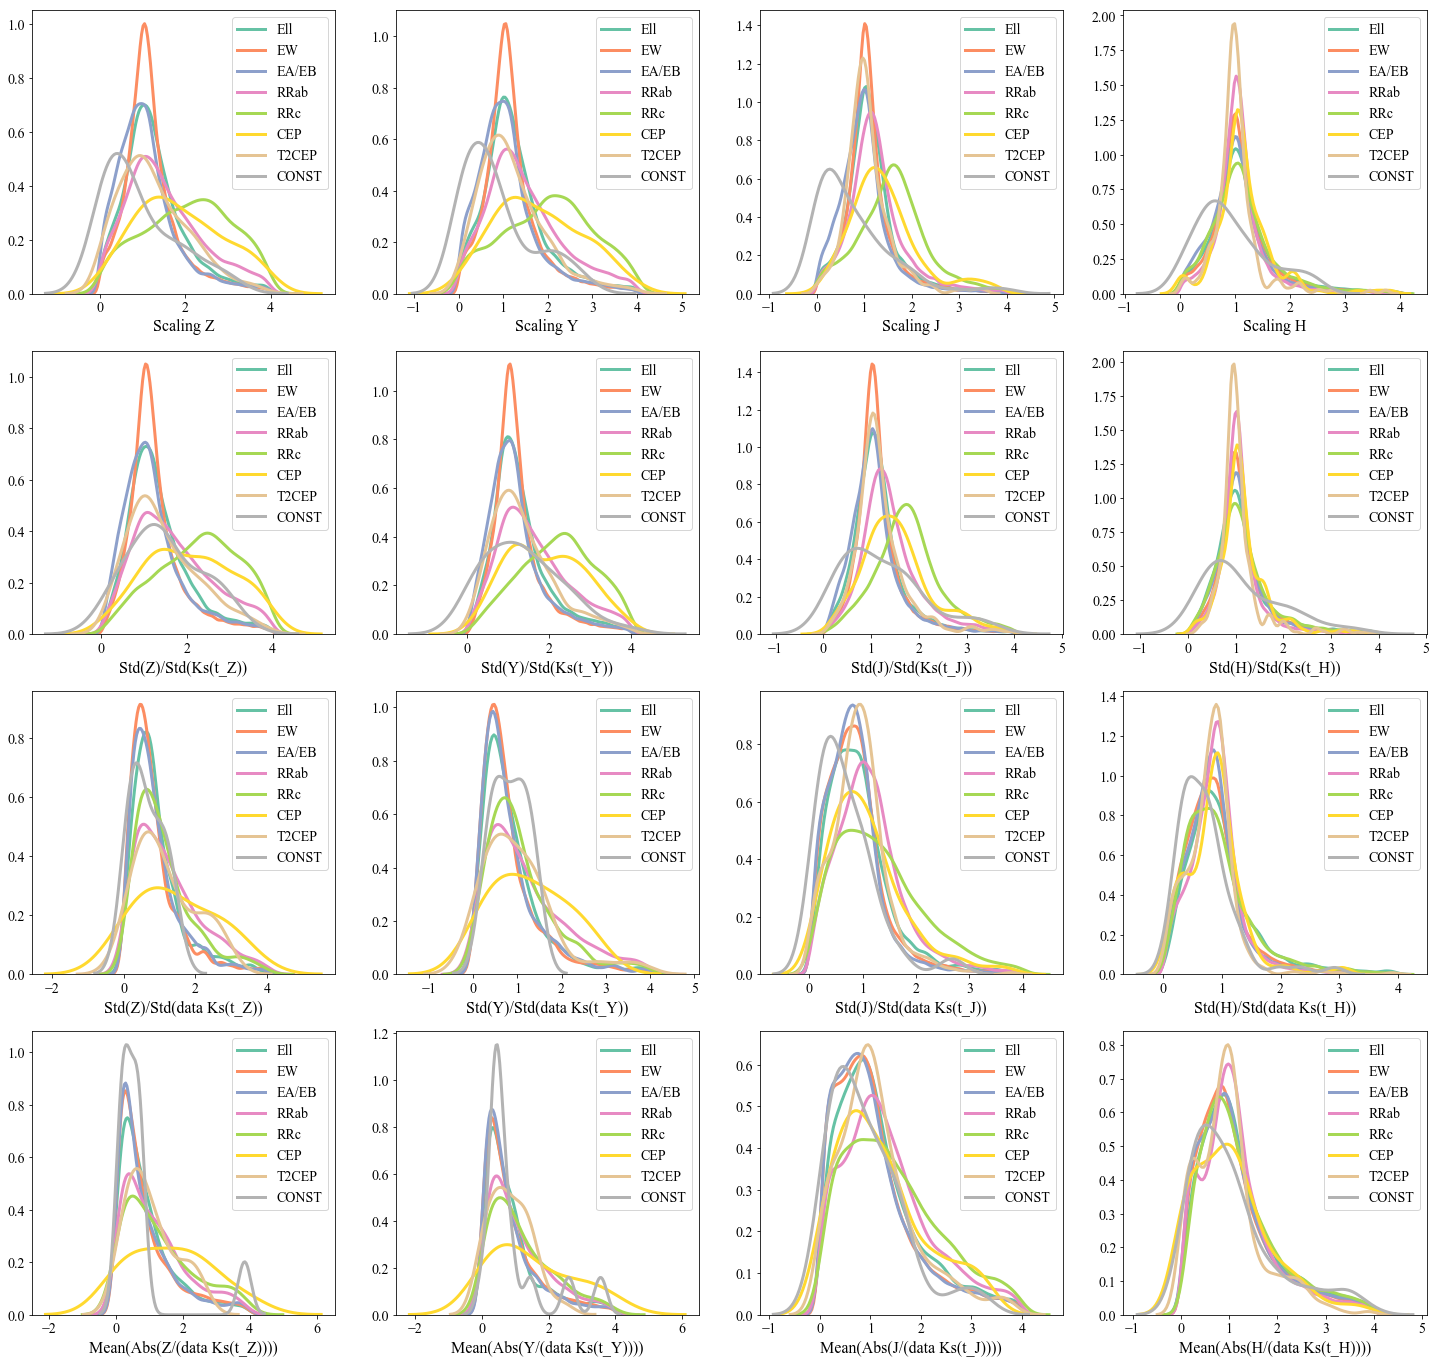

In [543]:
f,a=plt.subplots(4,4,figsize=[25.,24.])
for ii,z in enumerate(['Z','Y','J','H']):
    plt.sca(a[0][ii])
    for jj,l in enumerate(['Ell','EW','EA/EB','RRab','RRc','CEP','T2CEP','CONST']):
        sns.kdeplot(var_dataset['%s_scale'%z][(var_dataset['log10_fap_ls']<-10)&(var_dataset['var_class']==l)],
                    clip=[0,4],label=l,lw=3,color=sns.color_palette('Set2',n_colors=8)[jj])
    plt.xlabel('Scaling %s'%z)
    plt.legend()
    plt.sca(a[1][ii])
    for jj,l in enumerate(['Ell','EW','EA/EB','RRab','RRc','CEP','T2CEP','CONST']):
        sns.kdeplot(var_dataset['%s_model'%z][(var_dataset['log10_fap_ls']<-10)&(var_dataset['var_class']==l)],
                    clip=[0,4],label=l,lw=3,color=sns.color_palette('Set2',n_colors=8)[jj])
    plt.xlabel('Std({0})/Std(Ks(t_{0}))'.format(z))
    plt.legend()
    plt.sca(a[2][ii])
    for jj,l in enumerate(['Ell','EW','EA/EB','RRab','RRc','CEP','T2CEP','CONST']):
        sns.kdeplot(var_dataset['%s_contemp_std'%z][(var_dataset['log10_fap_ls']<-10)&(var_dataset['var_class']==l)],
                    clip=[0,4],label=l,lw=3,color=sns.color_palette('Set2',n_colors=8)[jj])
    plt.xlabel('Std({0})/Std(data Ks(t_{0}))'.format(z))
    plt.legend()
    plt.sca(a[3][ii])
    for jj,l in enumerate(['Ell','EW','EA/EB','RRab','RRc','CEP','T2CEP','CONST']):
        sns.kdeplot(var_dataset['%s_contemp_abs'%z][(var_dataset['log10_fap_ls']<-10)&(var_dataset['var_class']==l)],
                    clip=[0,4],label=l,lw=3,color=sns.color_palette('Set2',n_colors=8)[jj])
    plt.xlabel('Mean(Abs({0}/(data Ks(t_{0}))))'.format(z))
    plt.legend()

/data/jls/python3.5/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/data/jls/python3.5/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[]

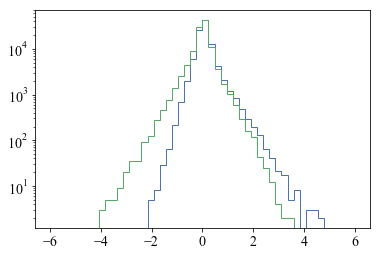

In [558]:
plt.hist(np.log10(var_dataset['J_model']),histtype='step',bins=50,range=[-6,6]);
plt.hist(np.log10(var_dataset['J_scale']),histtype='step',bins=50,range=[-6,6]);
# plt.hist(np.log10(var_dataset['J_contemp_std']),histtype='step',bins=50,range=[-6,6]);
# plt.hist(np.log10(var_dataset['J_contemp_abs']),histtype='step',bins=50,range=[-6,6]);

plt.semilogy()

In [570]:
np.count_nonzero(np.log10(var_dataset['Z_model'])
                 >np.nanmedian(var_dataset['Z_model'])
                 +10.*.25*np.diff(np.nanpercentile(np.log10(var_dataset['Z_model']),[5.,95.]))[0])

4

In [563]:
np.nanmedian(var_dataset['J_scale'])-10.*.25*np.diff(np.nanpercentile(np.log10(var_dataset['J_scale']),[5.,95.]))

array([-2.29347144])

In [573]:
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total_o.pkl', 'rb') as f:
    var_dataset_OLD = pickle.load(f)
with open('/local/scratch_2/jls/virac_classifier/variable/edr3/variable_features_total.pkl', 'rb') as f:
    var_dataset_NEW = pickle.load(f)

In [574]:
len(var_dataset_OLD), len(var_dataset_NEW)

(440660, 440660)

In [596]:
var_dataset_NEW.dtypes[220:250]

a0_a3_double        float64
phi2_phi1           float64
phi2_phi1_double    float64
a1_a2               float64
a1_a2_double        float64
phi3_phi1           float64
phi3_phi1_double    float64
a1_a3               float64
a1_a3_double        float64
phi3_phi2           float64
phi3_phi2_double    float64
a2_a3               float64
a2_a3_double        float64
dtype: object

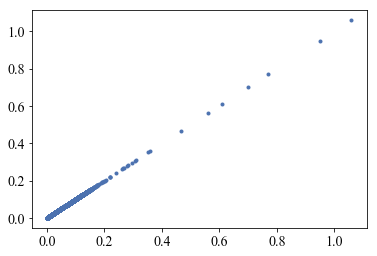

In [577]:
plt.plot(var_dataset_OLD['amp_3'],var_dataset_NEW['amp_3'],'.')